## Intuition behind Gradient Boosting
The logic behind gradient boosting is simple, (can be understood intuitively, without using mathematical notation). I expect that whoever is reading this post might be familiar with simple linear regression modeling.

A basic assumption of linear regression is that sum of its residuals is 0, i.e. the residuals should be spread randomly around zero.

Now think of these residuals as mistakes committed by our predictor model. Although, tree-based models (considering decision tree as base models for our gradient boosting here) are not based on such assumptions, but if we think logically (not statistically) about this assumption, we might argue that, if we are able to see some pattern of residuals around 0, we can leverage that pattern to fit a model.

So, the intuition behind gradient boosting algorithm is to repetitively leverage the patterns in residuals and strengthen a model with weak predictions and make it better. Once we reach a stage that residuals do not have any pattern that could be modeled, we can stop modeling residuals (otherwise it might lead to overfitting). Algorithmically, we are minimizing our loss function, such that test loss reach its minima.

In summary, 

• We first model data with simple models and analyze data for errors. 

• These errors signify data points that are difficult to fit by a simple model. 

• Then for later models, we particularly focus on those hard to fit data to get them right. 

• In the end, we combine all the predictors by giving some weights to each predictor.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from IPython.display import display
from fastai.imports import *
from sklearn import metrics

The data

In [2]:
x = np.arange(0,50)
x = pd.DataFrame({'x':x})

# just random uniform distributions in differnt range

y1 = np.random.uniform(10,15,10)
y2 = np.random.uniform(20,25,10)
y3 = np.random.uniform(0,5,10)
y4 = np.random.uniform(30,32,10)
y5 = np.random.uniform(13,17,10)

y = np.concatenate((y1,y2,y3,y4,y5))
y = y[:,None]

In [3]:
%load_ext autoreload
%autoreload 2

In [7]:
def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

In [23]:
class DecisionTree():
    def __init__(self, x, y, idxs = None, min_leaf=2):
        if idxs is None: idxs=np.arange(len(y))
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.n,self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i)
        if self.score == float('inf'): return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
        self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

    def find_better_split(self, var_idx):
        x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y,sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

        for i in range(0,self.n-self.min_leaf-1):
            xi,yi = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            if i<self.min_leaf or xi==sort_x[i+1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,xi

    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = 'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s += '; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)

## 1. Fit a simple linear regressor or decision tree on data (I have chosen decision tree in my code) [call x as input and y as output]

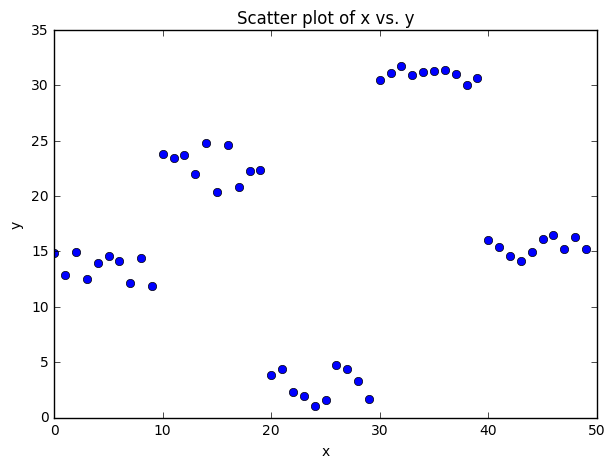

In [28]:
plt.figure(figsize=(7,5))
plt.plot(x,y, 'o')
plt.title("Scatter plot of x vs. y")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## 2. Calculate error residuals. Actual target value, minus predicted target value [e1= y - y_predicted1 ]
## 3. Fit a new model on error residuals as target variable with same input variables [call it e1_predicted]
## 4. Add the predicted residuals to the previous predictions
## [y_predicted2 = y_predicted1 + e1_predicted]
## 5. Fit another model on residuals that is still left. i.e. [e2 = y - y_predicted2] and repeat steps 2 to 5 until it starts overfitting or the sum of residuals become constant. Overfitting can be controlled by consistently checking accuracy on validation data.

/Users/WeiYu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


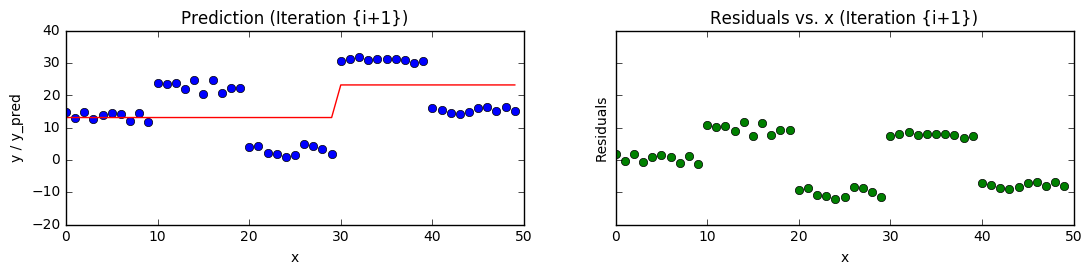

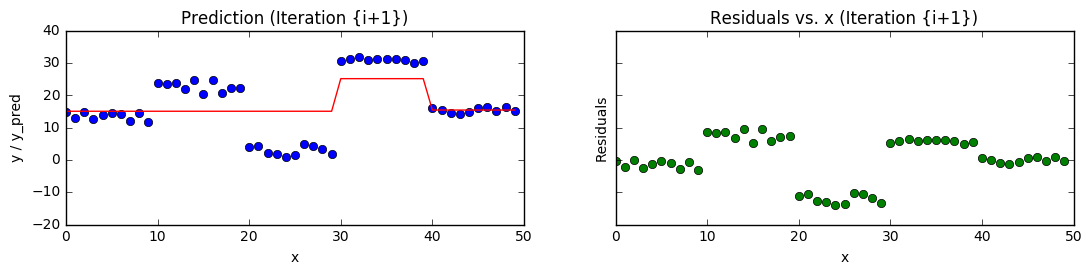

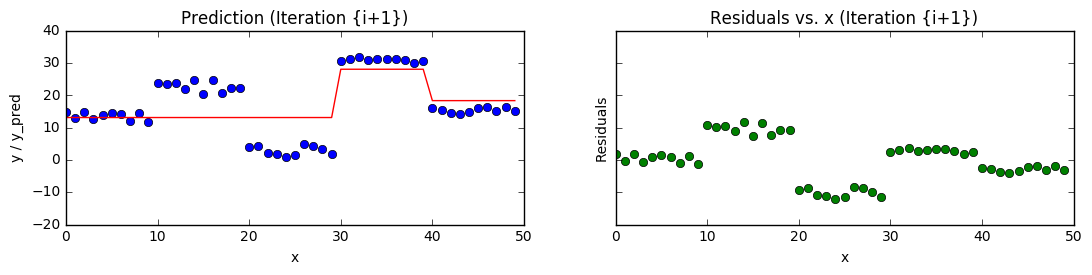

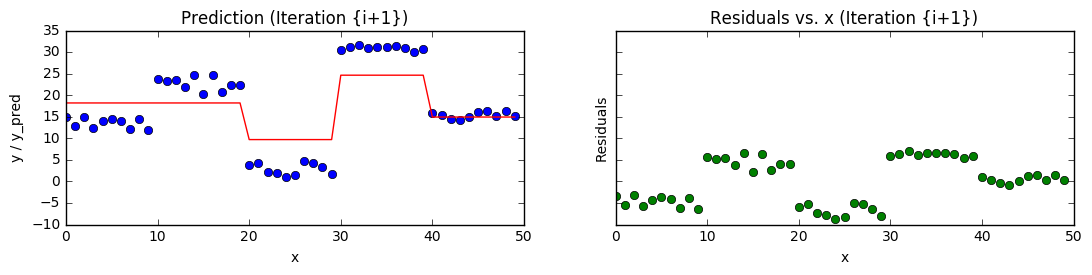

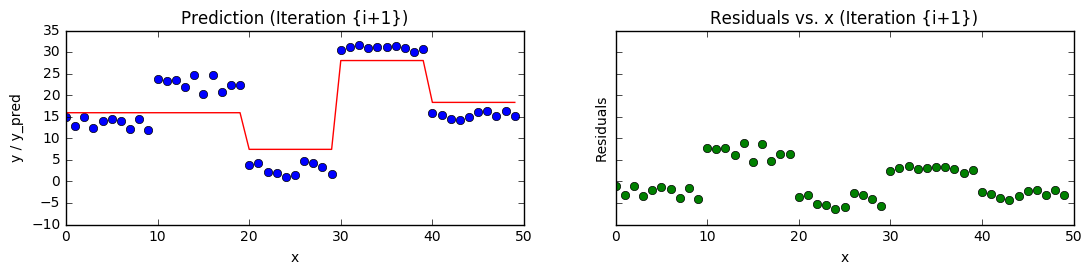

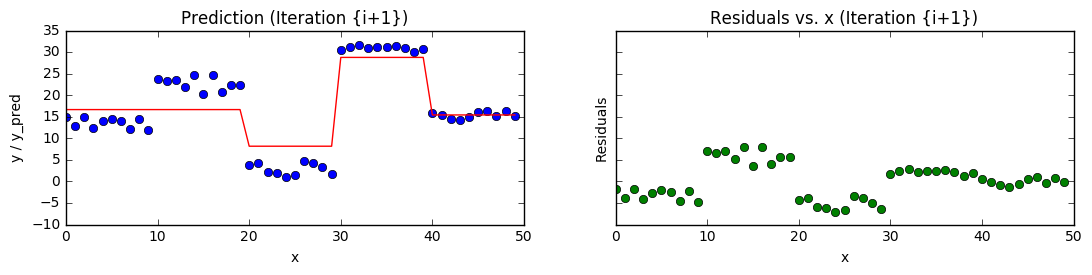

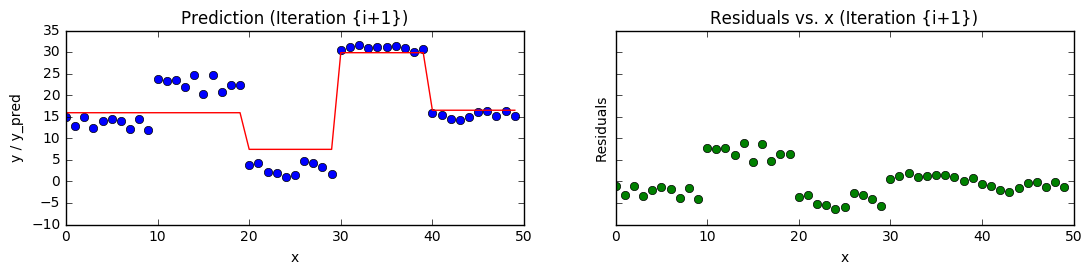

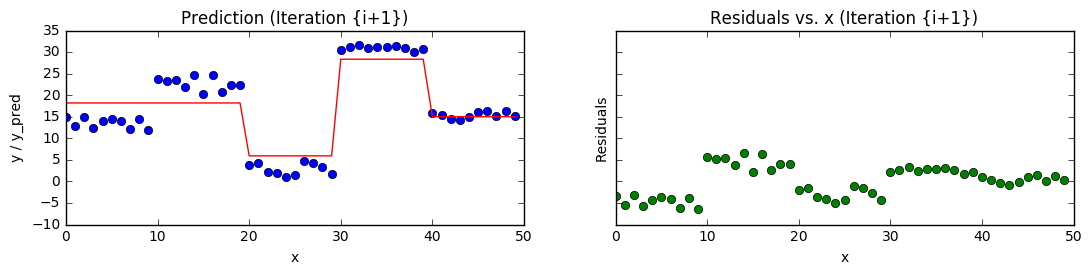

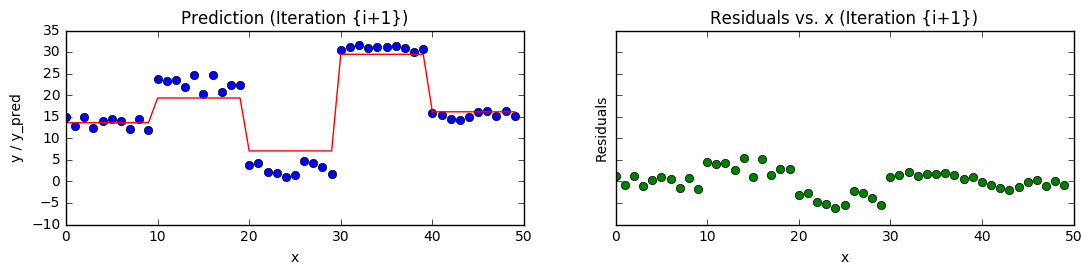

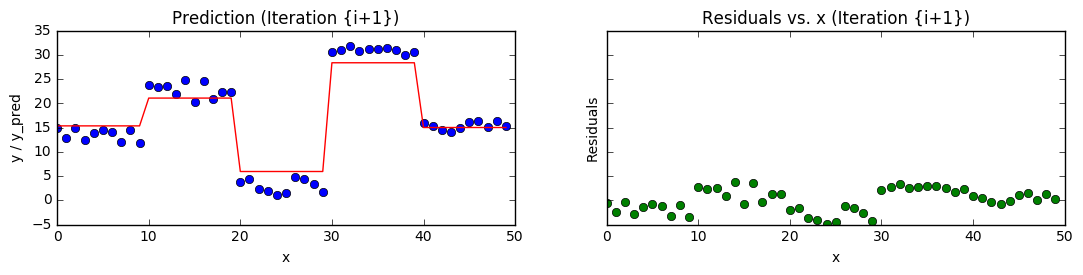

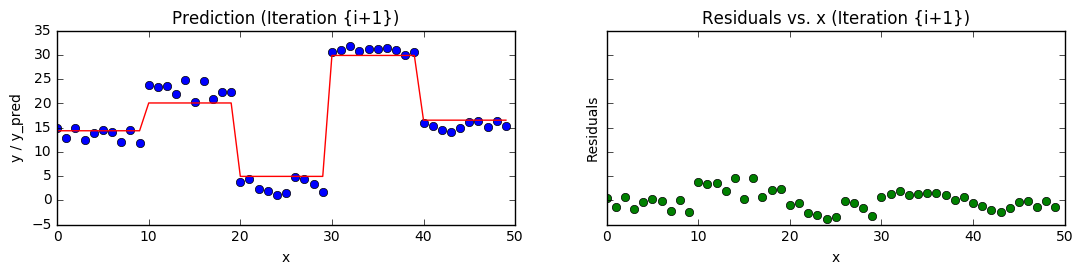

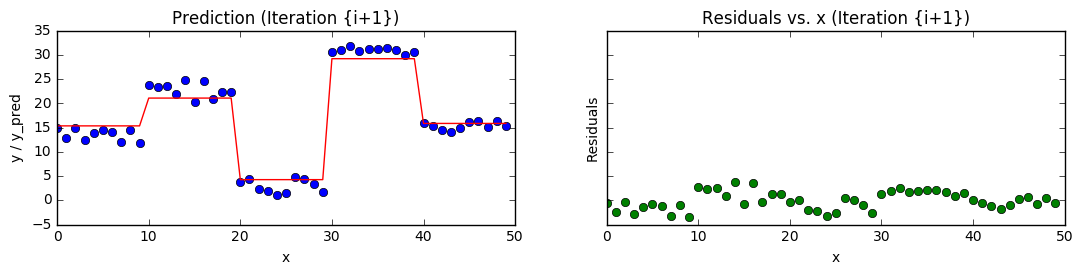

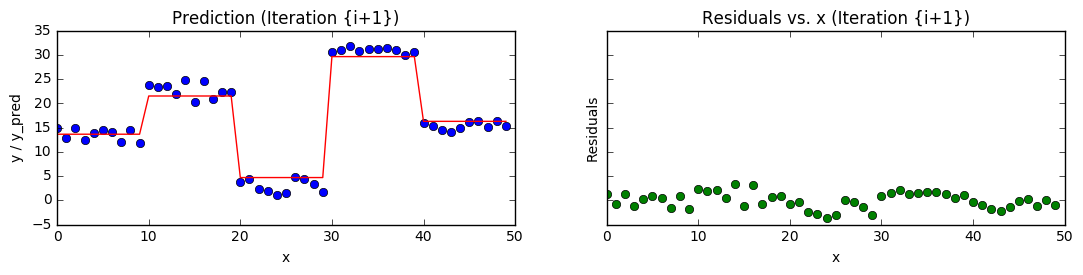

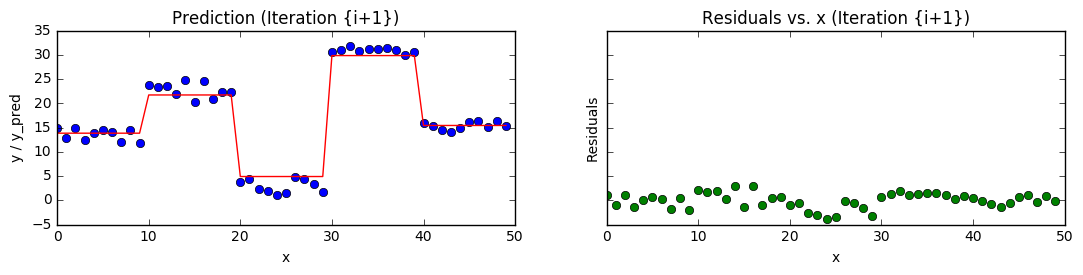

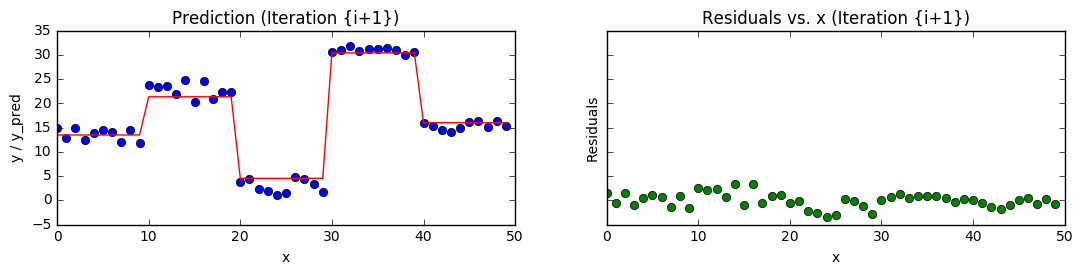

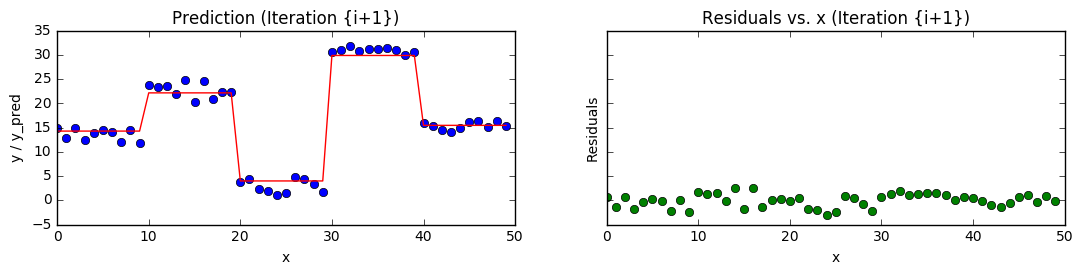

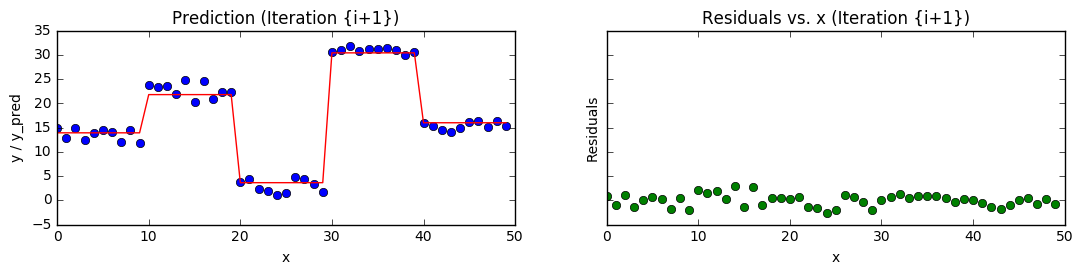

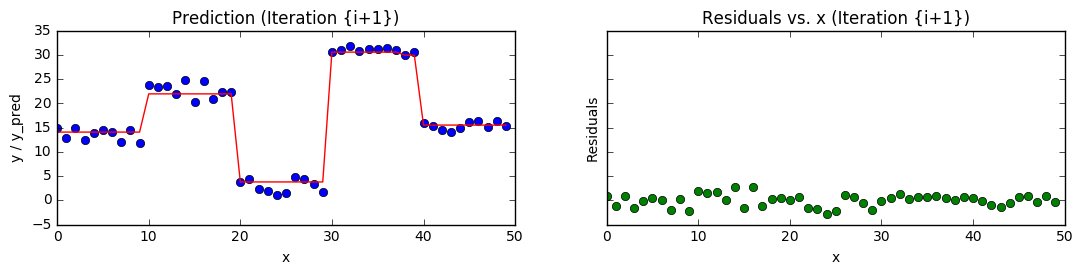

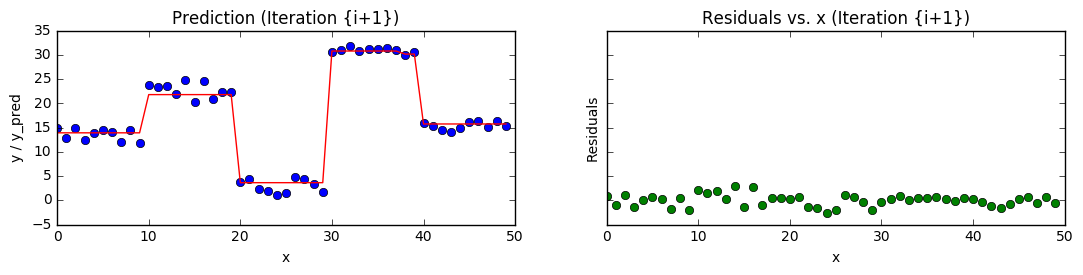

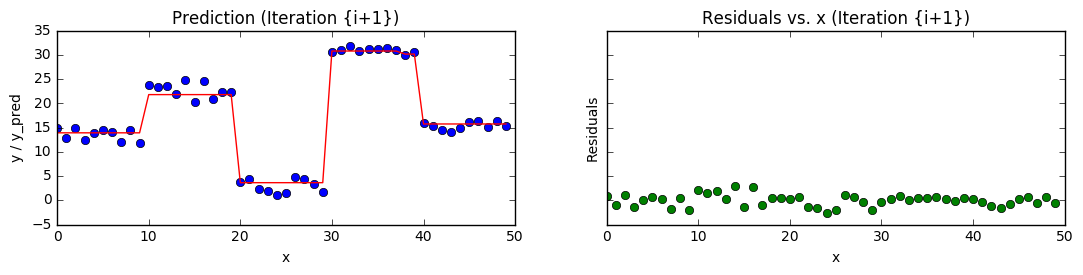

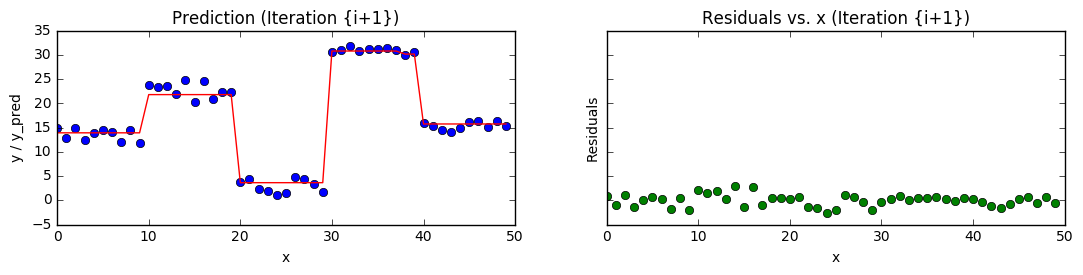

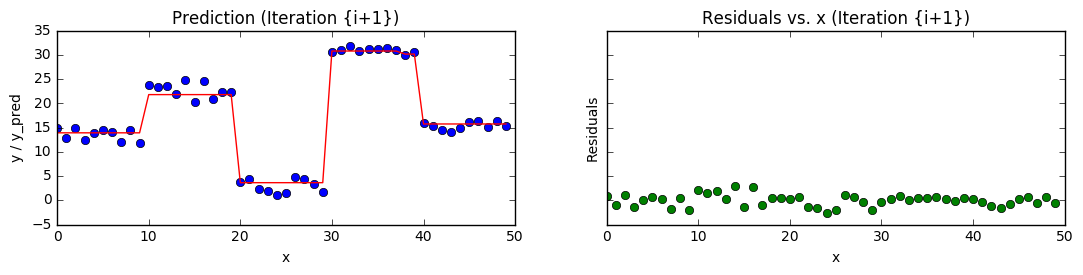

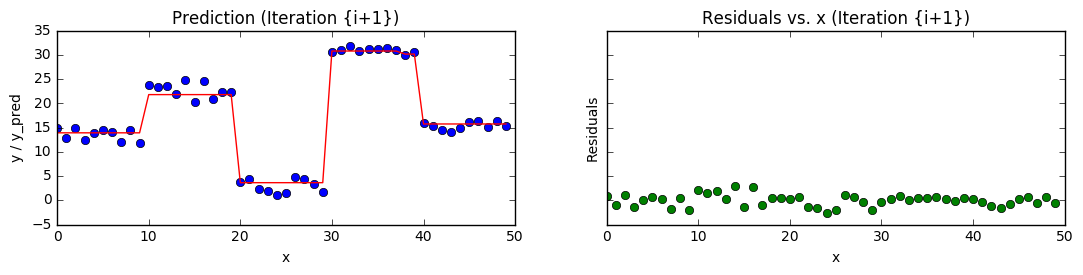

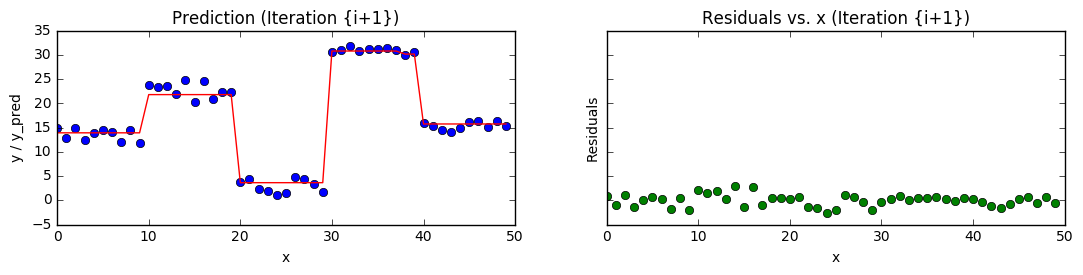

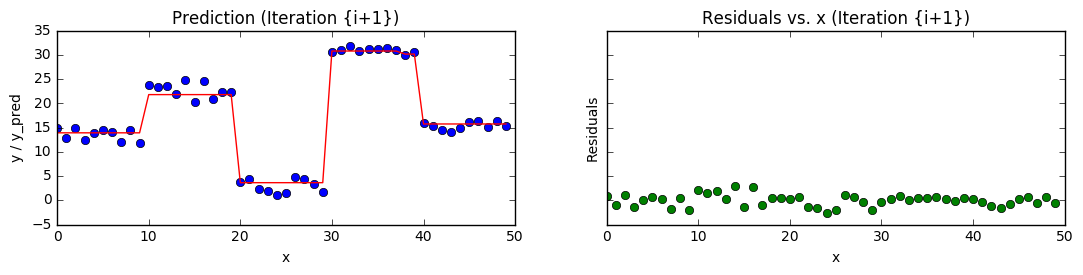

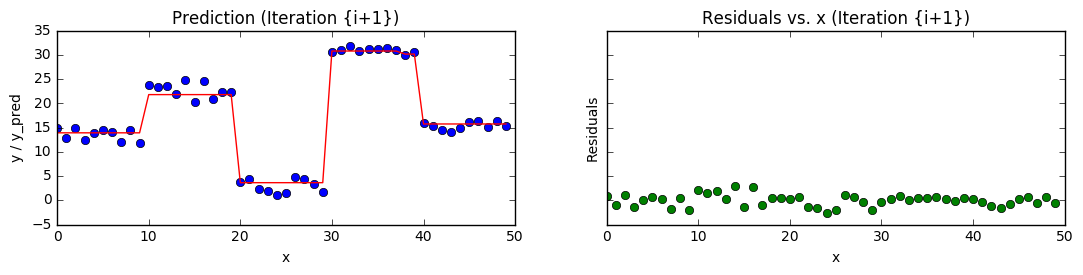

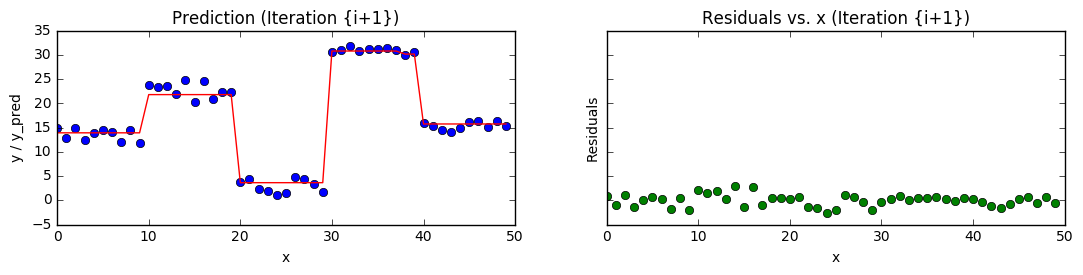

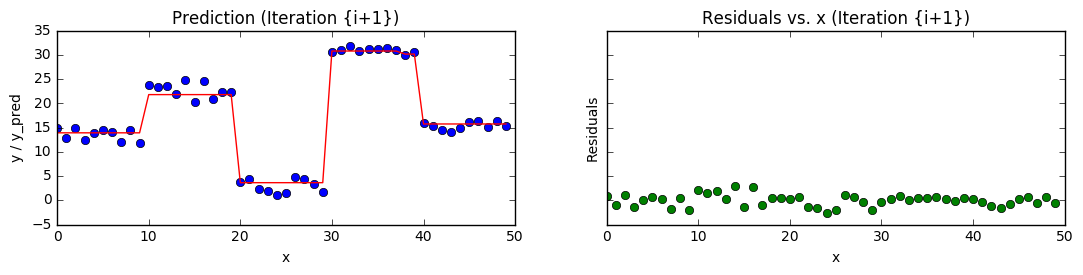

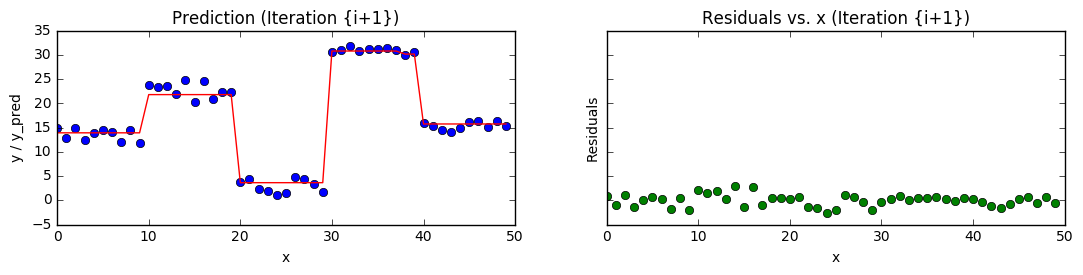

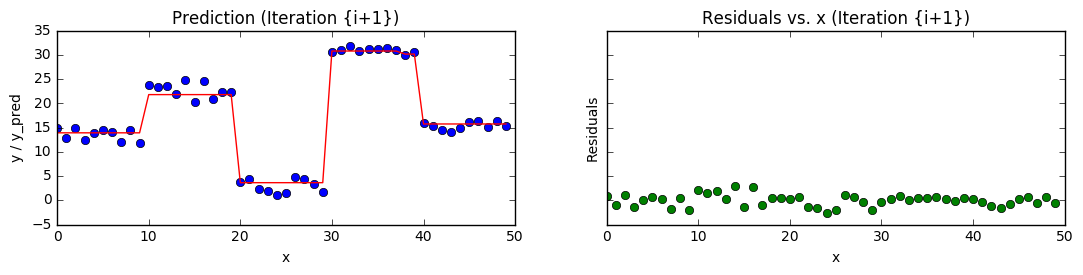

In [27]:
xi = x # initialization of input
yi = y # initialization of target
# x,y --> use where no need to change original y
ei = 0 # initialization of error
n = len(yi)  # number of rows
predf = 0 # initial prediction 0

for i in range(30): # like n_estimators
    tree = DecisionTree(xi,yi)
    tree.find_better_split(0)
    
    r = np.where(xi == tree.split)[0][0]    
    
    left_idx = np.where(xi <= tree.split)[0]
    right_idx = np.where(xi > tree.split)[0]
    
    predi = np.zeros(n)
    np.put(predi, left_idx, np.repeat(np.mean(yi[left_idx]), r))  # replace left side mean y
    np.put(predi, right_idx, np.repeat(np.mean(yi[right_idx]), n-r))  # right side mean y
    
    predi = predi[:,None]  # make long vector (nx1) in compatible with y
    predf = predf + predi  # final prediction will be previous prediction value + new prediction of residual
    
    ei = y - predf  # needed originl y here as residual always from original y    
    yi = ei # update yi as residual to reloop
    
    
    # plotting after prediction
    xa = np.array(x.x) # column name of x is x 
    order = np.argsort(xa)
    xs = np.array(xa)[order]
    ys = np.array(predf)[order]
    
    #epreds = np.array(epred[:,None])[order]

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (13,2.5))

    ax1.plot(x,y, 'o')
    ax1.plot(xs, ys, 'r')
    ax1.set_title('Prediction (Iteration {i+1})')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y / y_pred')

    ax2.plot(x, ei, 'go')
    ax2.set_title('Residuals vs. x (Iteration {i+1})')
    ax2.set_xlabel('x')
    ax2.set_ylabel('Residuals')